Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

sns.set(style="whitegrid")

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\igorv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igorv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igorv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Load and Preview Data

In [5]:
df = pd.read_csv('Phishing email small.csv')

df = df.drop(columns=['Unnamed: 0'])

df.head()

,Email Text,Label
0,special sale legal operating systems giveaway ...,1
1,URL: http://www.askbjoernhansen.com/archives/2...,0
2,no more injections,1
3,"intrastate gas hi daren , bryan hull gave me y...",0
4,"Jim Whitehead wrote:\n> So, after shutting off...",0


Check Missing and Duplicate Values

In [7]:
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

df = df.drop_duplicates()
print("Number of duplicate rows after removal:", df.duplicated().sum())

Missing values per column:
 Email Text    0
Label         0
dtype: int64
Number of duplicate rows: 73
Number of duplicate rows after removal: 0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1791 entries, 0 to 1863
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  1791 non-null   object
 1   Label       1791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.0+ KB


Label Distribution

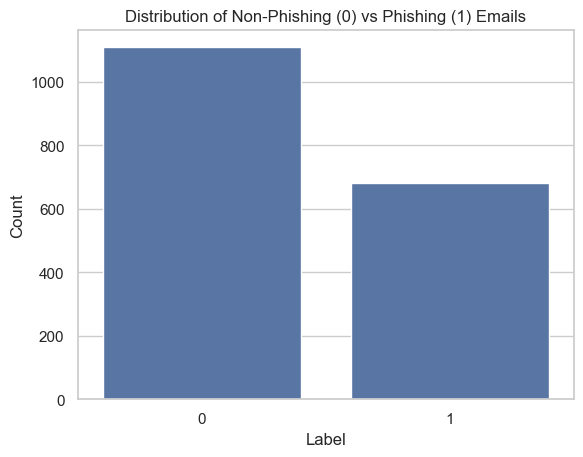

Label distribution (in %):
 Label
0    61.920715
1    38.079285
Name: proportion, dtype: float64


In [10]:
label_distribution = df['Label'].value_counts(normalize=True) * 100
sns.countplot(data=df, x='Label')
plt.title('Distribution of Non-Phishing (0) vs Phishing (1) Emails')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

print("Label distribution (in %):\n", label_distribution)

Text Preprocessing

In [12]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['Processed_Text'] = df['Email Text'].apply(preprocess_text)

Email Length Analysis

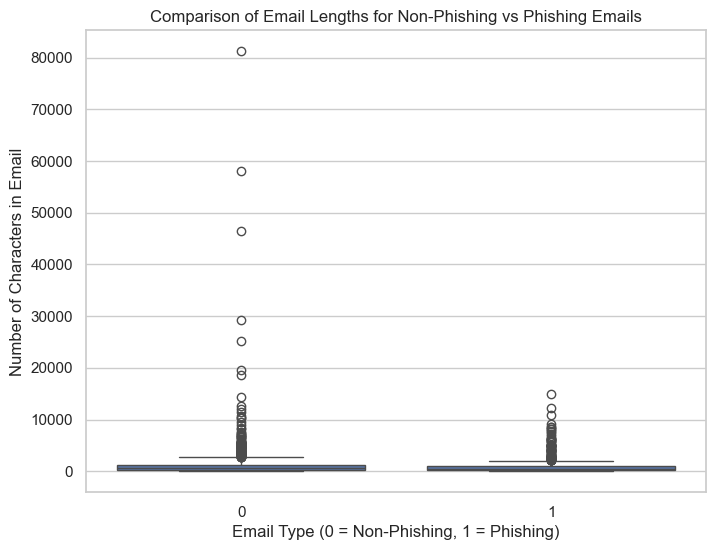

In [14]:
df['Email_Length'] = df['Processed_Text'].apply(len)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Email_Length', data=df)
plt.title('Comparison of Email Lengths for Non-Phishing vs Phishing Emails')
plt.xlabel('Email Type (0 = Non-Phishing, 1 = Phishing)')
plt.ylabel('Number of Characters in Email')
plt.show()

Word and Character Count Analysis

In [16]:
df['word_count'] = df['Processed_Text'].apply(lambda x: len(x.split()))
df['char_count'] = df['Processed_Text'].apply(lambda x: len(x))
df['avg_word_length'] = df['char_count'] / df['word_count']

phishing_emails = df[df['Label'] == 1]
non_phishing_emails = df[df['Label'] == 0]

print("Results for Phishing Emails:")
print(phishing_emails[['word_count', 'char_count', 'avg_word_length']].describe())

print("\nResults for Non-Phishing Emails:")
print(non_phishing_emails[['word_count', 'char_count', 'avg_word_length']].describe())

Results for Phishing Emails:
        word_count    char_count  avg_word_length
count   682.000000    682.000000       681.000000
mean    139.646628   1010.680352         7.035741
std     213.508836   1582.002679         1.228256
min       0.000000      0.000000         2.823529
25%      39.000000    261.250000         6.451613
50%      67.000000    459.500000         6.976115
75%     135.750000    981.000000         7.500000
max    1905.000000  15032.000000        26.500000

Results for Non-Phishing Emails:
         word_count    char_count  avg_word_length
count   1109.000000   1109.000000      1109.000000
mean     185.357078   1355.693417         7.337571
std      532.292261   3837.522880         1.184529
min        1.000000      5.000000         4.500000
25%       39.000000    289.000000         6.692308
50%       90.000000    648.000000         7.232143
75%      176.000000   1272.000000         7.824742
max    11363.000000  81225.000000        16.285714


N-Gram Analysis

In [18]:
def get_top_ngrams(data, ngram_range=(2, 4), top_n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(data)
    ngrams = vectorizer.get_feature_names_out()
    ngram_counts = X.sum(axis=0).A1
    ngram_freq = dict(zip(ngrams, ngram_counts))
    ngram_freq_sorted = dict(sorted(ngram_freq.items(), key=lambda item: item[1], reverse=True))
    return ngram_freq_sorted

non_phishing_emails = df[df['Label'] == 0]['Processed_Text']
phishing_emails = df[df['Label'] == 1]['Processed_Text']

Non-Phishing N-Grams

In [20]:
print("Top 10 Bigrams, Trigrams, and Quadrigrams for Non-Phishing Emails:")
non_phishing_ngrams = get_top_ngrams(non_phishing_emails)
bigrams_non_phishing = {ngram: count for ngram, count in non_phishing_ngrams.items() if len(ngram.split()) == 2}
trigrams_non_phishing = {ngram: count for ngram, count in non_phishing_ngrams.items() if len(ngram.split()) == 3}
quadrigrams_non_phishing = {ngram: count for ngram, count in non_phishing_ngrams.items() if len(ngram.split()) == 4}

print("\nTop 10 Bigrams (Non-Phishing):")
for ngram, count in list(bigrams_non_phishing.items())[:10]:
    print(f"{ngram}: {count}")

print("\nTop 10 Trigrams (Non-Phishing):")
for ngram, count in list(trigrams_non_phishing.items())[:10]:
    print(f"{ngram}: {count}")

print("\nTop 10 Quadrigrams (Non-Phishing):")
for ngram, count in list(quadrigrams_non_phishing.items())[:10]:
    print(f"{ngram}: {count}")

Top 10 Bigrams, Trigrams, and Quadrigrams for Non-Phishing Emails:

Top 10 Bigrams (Non-Phishing):
hou ect: 451
ect ect: 426
enron com: 176
enron enron: 172
dow jones: 153
original message: 150
let know: 147
mailing list: 147
new york: 141
http www: 127

Top 10 Trigrams (Non-Phishing):
hou ect ect: 374
ect ect cc: 107
copyright dow jones: 97
inc right reserved: 72
dow jones company: 68
jones company inc: 68
please let know: 68
corp enron enron: 66
alias dbcaps data: 65
database alias dbcaps: 65

Top 10 Quadrigrams (Non-Phishing):
hou ect ect cc: 93
copyright dow jones company: 68
dow jones company inc: 68
database alias dbcaps data: 65
unknown database alias dbcaps: 65
irish linux user group: 56
unsubscription information list maintainer: 56
company inc right reserved: 55
information list maintainer listmasterlinuxie: 55
jones company inc right: 55


Phishing N-Grams

In [22]:
print("\nTop 10 Bigrams, Trigrams, and Quadrigrams for Phishing Emails:")
phishing_ngrams = get_top_ngrams(phishing_emails)
bigrams_phishing = {ngram: count for ngram, count in phishing_ngrams.items() if len(ngram.split()) == 2}
trigrams_phishing = {ngram: count for ngram, count in phishing_ngrams.items() if len(ngram.split()) == 3}
quadrigrams_phishing = {ngram: count for ngram, count in phishing_ngrams.items() if len(ngram.split()) == 4}

print("\nTop 10 Bigrams (Phishing):")
for ngram, count in list(bigrams_phishing.items())[:10]:
    print(f"{ngram}: {count}")

print("\nTop 10 Trigrams (Phishing):")
for ngram, count in list(trigrams_phishing.items())[:10]:
    print(f"{ngram}: {count}")

print("\nTop 10 Quadrigrams (Phishing):")
for ngram, count in list(quadrigrams_phishing.items())[:10]:
    print(f"{ngram}: {count}")


Top 10 Bigrams, Trigrams, and Quadrigrams for Phishing Emails:

Top 10 Bigrams (Phishing):
email address: 112
http www: 106
br br: 84
web site: 69
looking statement: 61
broadcast email: 59
forward looking: 57
mailing list: 56
would like: 54
credit card: 42

Top 10 Trigrams (Phishing):
br br br: 81
forward looking statement: 52
call call call: 32
statement within meaning: 23
iit demokritos gr: 21
ragga dagga tm: 20
forward ooking statement: 19
remove subject line: 18
temple ragga dagga: 18
apple macintosh price: 17

Top 10 Quadrigrams (Phishing):
br br br br: 79
call call call call: 28
temple ragga dagga tm: 18
risk uncertainty could cause: 16
private security litigation reform: 15
security litigation reform act: 15
style font size lpx: 15
indicating certain action may: 14
based expectation estimate projection: 13
estimate projection time statement: 13


WordCloud for Non-Phishing Emails

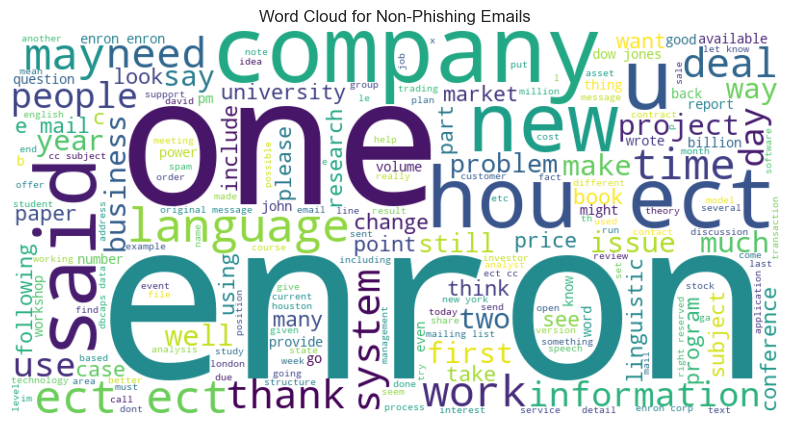

In [24]:
non_phishing_text = ' '.join(df[df['Label'] == 0]['Processed_Text'])
wordcloud_non_phishing = WordCloud(width=800, height=400, background_color='white').generate(non_phishing_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_phishing, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Phishing Emails')
plt.show()

WordCloud for Phishing Emails

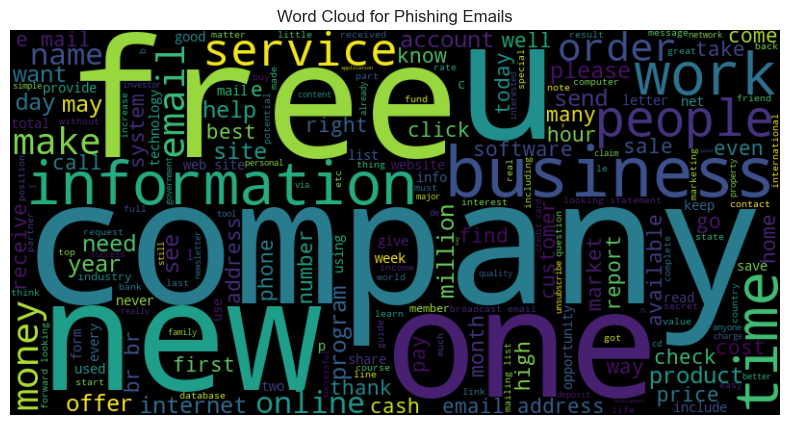

In [26]:
phishing_text = ' '.join(df[df['Label'] == 1]['Processed_Text'])
wordcloud_phishing = WordCloud(width=800, height=400, background_color='black').generate(phishing_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_phishing, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Phishing Emails')
plt.show()

Keyword Frequency Comparison

In [28]:
keywords = ['urgent', 'click', 'update', 'password', 'verify', 'account', 'free', 'win', 'email', 'money', 'online', 'information', 'business', 'name']

In [29]:
keyword_freq_phishing = {f"contains_{word}": df[df['Label'] == 1]['Processed_Text'].str.contains(word).mean() for word in keywords}

keyword_freq_non_phishing = {f"contains_{word}": df[df['Label'] == 0]['Processed_Text'].str.contains(word).mean() for word in keywords}

phishing_series = pd.Series(keyword_freq_phishing, name="Phishing Emails")
non_phishing_series = pd.Series(keyword_freq_non_phishing, name="Non-Phishing Emails")

comparison_df = pd.DataFrame({
    "Phishing Emails": phishing_series,
    "Non-Phishing Emails": non_phishing_series
})

print(comparison_df)

                      Phishing Emails  Non-Phishing Emails
contains_urgent              0.020528             0.004509
contains_click               0.247801             0.076646
contains_update              0.045455             0.066727
contains_password            0.020528             0.008115
contains_verify              0.011730             0.009017
contains_account             0.120235             0.068530
contains_free                0.288856             0.144274
contains_win                 0.234604             0.254283
contains_email               0.313783             0.283138
contains_money               0.171554             0.037872
contains_online              0.149560             0.057710
contains_information         0.243402             0.229937
contains_business            0.180352             0.087466
contains_name                0.162757             0.129847
